In [1]:
import os
import cv2
import glob
import torch
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import random
import math
from collections import defaultdict
from matplotlib import pyplot as plt
import umap

In [2]:
class SingleChannelImageDataset(Dataset):
    def __init__(self, folder_path, image_size=224, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.masks = {}

        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)

        # Store tumor type in self.labels (0 = fused glands, 1 = , 2 = solid)
        for img in self.image_files:
            slide_num = img.split("/")[-2].split("_")[0]
            tissue_num = img.split("_")[-1].split(".png")[0]
            mask_name = slide_num + "_" + tissue_num
            if mask_name not in self.masks:
                self.masks[mask_name] = np.zeros((image_size, image_size), dtype=np.uint8)
            else:
                img_array = np.array(Image.open(img).convert("L"))
                both_zero_mask = (img_array == 0) & (self.masks[mask_name] == 0)
                self.masks[mask_name] = np.where(both_zero_mask, 0, 255).astype(np.uint8)
            """if slide_num == "SQ1631":
                if tissue_num == "s1":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "s4":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "s2":
                    self.labels.append(0)
                else:
                    self.labels.append(2)
            elif slide_num == "SQ1634":
                if tissue_num == "s2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1635":
                if tissue_num == "s3" or tissue_num == "s4":
                    self.labels.append(2)
                elif tissue_num == "s1":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "s4":
                    self.labels.append(1)
                else:
                    self.labels.append(2)"""
            
            if slide_num == "SQ1631":
                if tissue_num == "s1" or tissue_num == "s2":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            elif slide_num == "SQ1632":
                if tissue_num == "s1" or tissue_num == "s3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            elif slide_num == "SQ1633":
                if tissue_num == "s1" or tissue_num == "s2":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            elif slide_num == "SQ1634":
                if tissue_num == "s1" or tissue_num == "s4":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1635":
                if tissue_num == "s1" or tissue_num == "s4":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            else:
                if tissue_num == "s1" or tissue_num == "s4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        slide_num = self.image_files[idx].split("/")[-2].split("_")[0]
        tissue_num = self.image_files[idx].split("_")[-1].split(".png")[0]
        mask_name = slide_num + "_" + tissue_num
        image = Image.open(self.image_files[idx]).convert('L') 
        mask = Image.fromarray(self.masks[mask_name])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, label, mask  # Return both image, label and mask

In [3]:
# define transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/cropped_v2/'
dataset = SingleChannelImageDataset(folder_path, image_size=224, transform=None)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
def plot_sampled_patches(image, coordinates, patch_size, ax):
    """
    Plot the original image with bounding boxes indicating the sampled patches.

    Parameters:
        image (np.ndarray): The input image as a NumPy array.
        coordinates (List[Tuple[int, int]]): List of top-left coordinates of sampled patches.
        patch_size (int): Size of the square patch.
    """
    image_copy = image.copy()
    image_array = np.array(image_copy)
    image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    
    for (x_start, y_start) in coordinates:
        top_left = (y_start, x_start)
        bottom_right = (y_start + patch_size, x_start + patch_size)
        cv2.rectangle(image, top_left, bottom_right, color=(255, 0, 0), thickness=1)

    ax.imshow(image)
    ax.axis('off')  # Turn off axes
    return ax

In [5]:
import numpy as np
from PIL import Image

def construct_patches(img, patch_size=32):  # Now takes a PIL Image object
    """
    Cuts a PIL Image object into patches and converts each patch to a NumPy array.

    Args:
        img: A PIL Image object.
        patch_size: Size of each square patch (default: 32 for 224x224 image).

    Returns:
        A list of NumPy arrays, where each array represents a patch.
        Returns None if there's an error processing the image.
    """
    img_array = np.array(img)  # Convert PIL Image to NumPy array
    patches = []
    for i in range(0, img_array.shape[0], patch_size):  # Iterate over rows
        for j in range(0, img_array.shape[0], patch_size):  # Iterate over columns
            patch = img_array[i:i + patch_size, j:j + patch_size,:]  # Extract patch
            patches.append(patch)

    return patches
    

In [6]:
def quilting_image(patches_a, patches_b, patch_size, percentage_a=0.5):
    """
    Reconstructs an image by randomly picking patches from two lists,
    with a specified percentage of patches coming from list A.

    Args:
        patches_a: A list of NumPy arrays (patches from image A).
        patches_b: A list of NumPy arrays (patches from image B).
        percentage_a: The percentage of patches to be selected from patches_a (default: 0.5).

    Returns:
        A PIL Image object representing the reconstructed image, or None if there's an error.
    """
    
    
    
    if len(patches_a) != len(patches_b):  # patch counts must match
        raise ValueError("Length of both lists must match!")
    
    num_rows = int(math.sqrt(len(patches_a)))  # number of patches per row is square root of length of patch list
    
    try:
        quilted_image = np.zeros((num_rows * patch_size, num_rows * patch_size), dtype=np.uint8)
        patch_index = 0
        for i in range(num_rows):
            for j in range(num_rows):
                # choose between A and B based on percentage_a
                if random.random() < percentage_a:  # random.random() returns a float between 0 and 1
                    chosen_patch = patches_a[patch_index]
                else:
                    chosen_patch = patches_b[patch_index]

                row_start = i * patch_size
                row_end = row_start + patch_size
                col_start = j * patch_size
                col_end = col_start + patch_size
                quilted_image[row_start:row_end, col_start:col_end] = chosen_patch
                patch_index += 1
        
        return Image.fromarray(quilted_image)

    except Exception as e:
        print(f"Error reconstructing image: {e}")
        return None

In [7]:
def sample_coordinates_from_roi(binary_image, max_patches, patch_size, overlap):
    """
    Randomly sample n coordinates from white regions (value 255) in a binary image.
    
    Args:
        binary_image: PIL Image or numpy array with binary values (0, 255)
        max_patches: maximum number of patches
        patch_size: the size of the patch
        overlap: acceptable overlap between patches
        
    Returns:
        numpy.ndarray: Array of shape (max_patches, 2) containing (x, y) coordinates
    """
    # convert PIL Image to numpy array if needed
    if isinstance(binary_image, Image.Image):
        img_array = np.array(binary_image)
    else:
        img_array = binary_image
        
    min_distance = patch_size - patch_size * overlap # calculate the minimum distance between each future sampled coordinate
    
    # find coordinates of white pixels in the mask image (value 255)
    white_pixels = np.where(img_array == 255)
    all_coords = np.column_stack((white_pixels[0], white_pixels[1]))
    
    # create a set of tuples for faster membership testing
    # note that we use (y,x) format for coordinates since that's how NumPy indexes images
    coords_set = set(map(tuple, all_coords))
    
    # find valid candidate points that have the bottom right coordinate also in white region
    valid_candidates = []
    valid_indices = []
    
    for idx, (y, x) in enumerate(all_coords):
        bottom_right_coord = (y + patch_size, x + patch_size)  # Note: offset is (x,y) but coords are (y,x)
        if bottom_right_coord in coords_set:
            valid_candidates.append((y, x))
            valid_indices.append(idx)
    
    valid_candidates = np.array(valid_candidates)
    
    # check if we have enough white pixels
    if len(valid_candidates) < max_patches:
        raise ValueError(f"Not enough valid candidates ({len(valid_candidates)}) to sample {max_patches} coordinates")
    
    # create a mask that will be updated to 0 in regions where points are already placed
    # we'll start with all 1s where valid points exist
    point_mask = np.zeros_like(img_array, dtype=bool)
    for y, x in valid_candidates:
        point_mask[y, x] = True
        
    # array to store sampled coordinates
    sampled_coords = []
    
    for _ in range(max_patches):
        # if we've eliminated all possible points, break
        if not np.any(point_mask):
            break
            
        # get indices where mask is True (valid points remain)
        remaining_y, remaining_x = np.where(point_mask)
        remaining_indices = np.arange(len(remaining_y))
        
        # shuffle to randomly sample
        np.random.shuffle(remaining_indices)
        
        # try points in random order
        found_point = False
        for idx in remaining_indices:
            y, x = remaining_y[idx], remaining_x[idx]
            
            # if this point and its offset are both valid
            if (y, x) in coords_set and (y + patch_size, x + patch_size) in coords_set:
                sampled_coords.append((y, x))
                found_point = True
                
                # create a circular mask to remove points that are too close
                y_indices, x_indices = np.ogrid[-y:img_array.shape[0]-y, -x:img_array.shape[1]-x]
                dist_mask = y_indices*y_indices + x_indices*x_indices <= min_distance*min_distance
                point_mask[dist_mask] = False
                
                break
        # we couldn't find another valid point        
        if not found_point:
            break
    
    # check if we got enough samples
    if len(sampled_coords) < max_patches:
        print(f"Warning: Could only find {len(sampled_coords)} points with minimum distance {min_distance} between patches.")
    return sampled_coords

<Axes: >

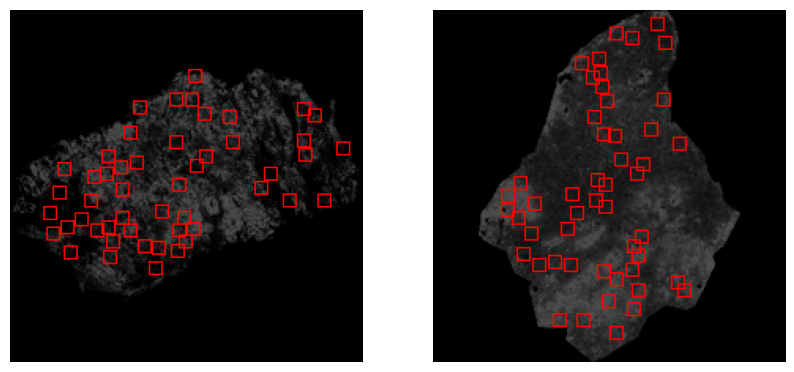

In [8]:
# Display some example images and their sampled coordinates
img1, label1, mask1 = dataset[0] # example 1
img2, label2, mask2 = dataset[27] # example 2
coords1 = sample_coordinates_from_roi(mask1, 50, 8, 0.3)
coords2 = sample_coordinates_from_roi(mask2, 50, 8, 0.3)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()
plot_sampled_patches(img1, coords1, 8, ax=axes[0])
plot_sampled_patches(img2, coords2, 8, ax=axes[1])

In [9]:
def extract_patches(image, coordinates, patch_size):
    """
    Extract patches from an image using the given coordinates.

    Parameters:
        image (np.ndarray): The input image as a NumPy array.
        coordinates (List[Tuple[int, int]]): List of top-left coordinates of patches.
        patch_size (int): Size of the square patch.

    Returns:
        List[np.ndarray]: A list of extracted patches as NumPy arrays.
    """
    patches = [
        image[x_start:x_start + patch_size, y_start:y_start + patch_size]
        for x_start, y_start in coordinates
    ]
    return patches

def create_patches_by_label(dataset, max_patches=50, patch_size=16, overlap=0.5):
    """
    Construct a quited image dataset synthesized existing Dataset object

    Args:
        dataset: a Dataset object that contains the images
        max_patches: maximum number of patches that can be drawn on the image
        patch_size: the size of the patches
        overlap: how much two patches can overlap each other

    Returns:
        A directory containing generated quilted images
    """
    patches_by_label = defaultdict(list)
    for img, label, mask in dataset:
        coords = sample_coordinates_from_roi(mask, max_patches, patch_size, overlap) # sample maximum 32 patches of size 8x8
        patches = extract_patches(np.array(img), coords, patch_size)
        patches_by_label[label].extend(patches)
    return patches_by_label

patches_by_label = create_patches_by_label(dataset, 100, 8, 0.2)

In [10]:
draw_size = 784 # there are 784 of 8x8 patches in a 224x224 picture
num_draws = 500  # draw pictures for example   

# randomly drawing 784 samples 3 times from the patches_by_label 
example_patches_0 = [random.sample(patches_by_label[0], draw_size) for _ in range (num_draws)]
example_patches_1 = [random.sample(patches_by_label[1], draw_size) for _ in range(num_draws)]

# shuffle the list of patches
random.shuffle(example_patches_0)
random.shuffle(example_patches_1)

In [46]:
positive_quilts = []
negative_quilts = []
for i in range(50):
    positive_quilted_np = np.array(quilting_image(random.choice(example_patches_0), random.choice(example_patches_0), 8, 0.5)).flatten()
    negative_quilted_np = np.array(quilting_image(random.choice(example_patches_0), random.choice(example_patches_1), 8, 0.5)).flatten()
    positive_quilts.append(positive_quilted_np)
    negative_quilts.append(negative_quilted_np)

/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP processing completed in 0.20 seconds
Processed 100 images with dimensionality 50176


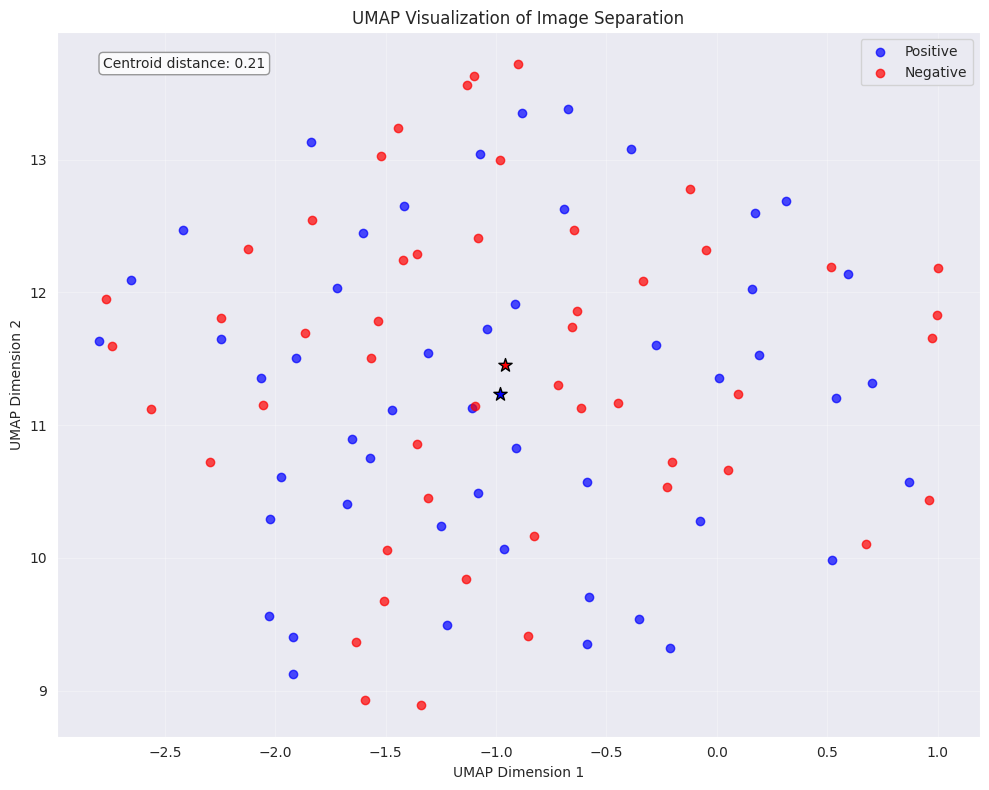

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
import time
from sklearn.preprocessing import StandardScaler

def umap_reduce(image_list_1, image_list_2, random_state=42):
    """
    Visualize separation between two sets of grayscale images using UMAP.
    
    Args:
        image_list_1: List of grayscale images (numpy arrays) for first class
        image_list_2: List of grayscale images (numpy arrays) for second class
        random_state: Random seed for reproducibility
        
    Returns:
        embeddings: 2D UMAP embeddings for all images
        labels: Class labels for each image (0 for first list, 1 for second)
    """
    # Start timer for performance measurement
    start_time = time.time()
    
    # Flatten images and combine into a single dataset
    # Efficient handling with numpy operations
    flattened_images = []
    labels = []
    
    # Process first image list
    for img_np in image_list_1:
        # Flatten the 2D image into a 1D array
        flattened_images.append(img_np.flatten())
        labels.append(0)  # Label 0 for first class
    
    # Process second image list
    for img_np in image_list_2:
        flattened_images.append(img_np.flatten())
        labels.append(1)  # Label 1 for second class
    
    # Convert to numpy arrays for faster processing
    X = np.array(flattened_images)
    labels = np.array(labels)
    
    # Standardize features for better UMAP performance
    # Zero mean and unit variance normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply UMAP reduction
    # n_neighbors: Controls preservation of local vs global structure
    # min_dist: Controls tightness of embedding points
    # n_components: Dimension of target space (2D for visualization)
    umap_reducer = umap.UMAP(n_neighbors=15, 
                              min_dist=0.1,
                              n_components=2,
                              metric='euclidean',
                              random_state=random_state)
    
    # Fit and transform data to get 2D embeddings
    embeddings = umap_reducer.fit_transform(X_scaled)
    
    # Performance logging
    elapsed_time = time.time() - start_time
    print(f"UMAP processing completed in {elapsed_time:.2f} seconds")
    print(f"Processed {len(X)} images with dimensionality {X.shape[1]}")
    
    return embeddings, labels

def plot_separation(embeddings, labels, title="UMAP Visualization of Image Separation"):
    """
    Plot the 2D UMAP embeddings with color-coded classes.
    
    Args:
        embeddings: 2D UMAP embeddings
        labels: Class labels for each point
        title: Plot title
    """
    plt.figure(figsize=(10, 8))
    
    # Separate points by class for efficient plotting
    negative_mask = labels == 0
    positive_mask = labels == 1
    
    # Plot each class with different colors
    plt.scatter(embeddings[negative_mask, 0], embeddings[negative_mask, 1], 
                c='blue', label='Positive', alpha=0.7)
    plt.scatter(embeddings[positive_mask, 0], embeddings[positive_mask, 1], 
                c='red', label='Negative', alpha=0.7)
    
    plt.title(title)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Calculate separation metrics
    negative_points = embeddings[negative_mask]
    positive_points = embeddings[positive_mask]
    
    # Calculate centroids
    negative_centroid = np.mean(negative_points, axis=0)
    positive_centroid = np.mean(positive_points, axis=0)
    
    # Distance between centroids
    centroid_distance = np.linalg.norm(negative_centroid - positive_centroid)
    
    # Highlight centroids
    plt.scatter(negative_centroid[0], negative_centroid[1], c='blue', s=100, marker='*', edgecolors='black')
    plt.scatter(positive_centroid[0], positive_centroid[1], c='red', s=100, marker='*', edgecolors='black')
    
    # Add centroid distance info
    plt.annotate(f"Centroid distance: {centroid_distance:.2f}", 
                 xy=(0.05, 0.95), 
                 xycoords='axes fraction', 
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    return plt

# Example usage (assuming you have two image lists)
# Example assuming you have image_list_1 and image_list_2
embeddings, labels = umap_reduce(negative_quilts, positive_quilts)
plot = plot_separation(embeddings, labels)
plot.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.004s...
[t-SNE] Computed neighbors for 100 samples in 0.321s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 49.785805
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.780838
[t-SNE] KL divergence after 1000 iterations: 0.728265
t-SNE processing completed in 0.99 seconds
Processed 100 images with dimensionality 50176


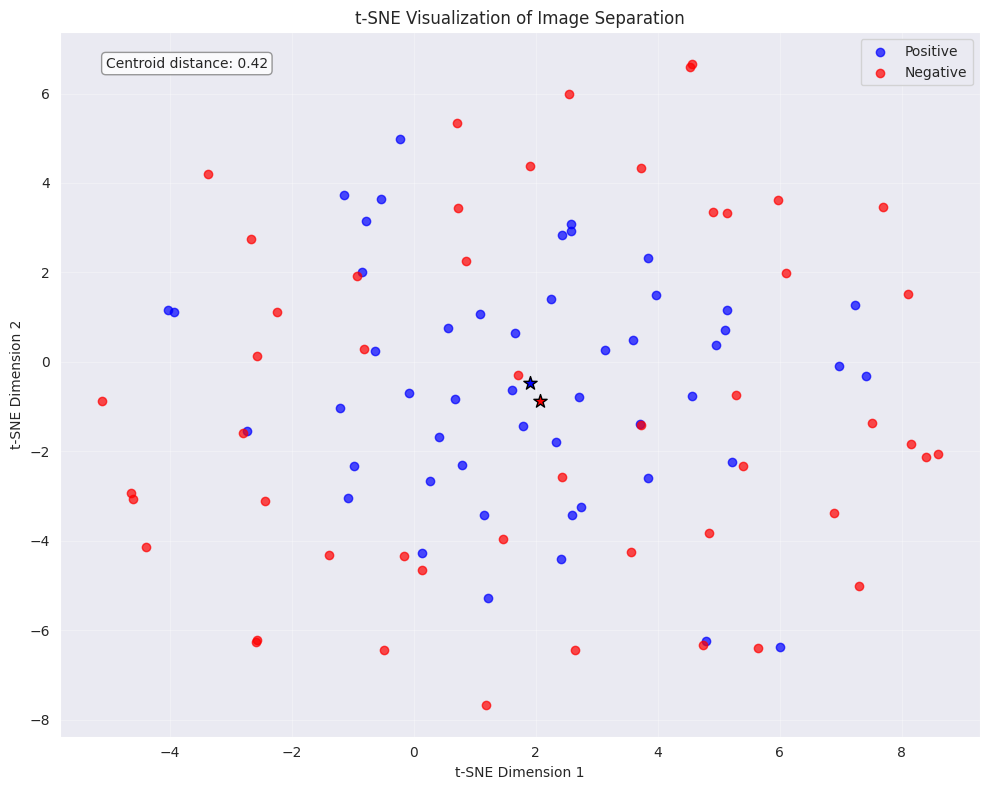

In [48]:
from sklearn.manifold import TSNE  # Import t-SNE from sklearn

def tsne_reduce(image_list_1, image_list_2, random_state=42):
    """
    Visualize separation between two sets of grayscale images using UMAP.
    
    Args:
        image_list_1: List of grayscale images (numpy arrays) for first class
        image_list_2: List of grayscale images (numpy arrays) for second class
        random_state: Random seed for reproducibility
        
    Returns:
        embeddings: 2D UMAP embeddings for all images
        labels: Class labels for each image (0 for first list, 1 for second)
    """
    # Start timer for performance measurement
    start_time = time.time()
    
    # Flatten images and combine into a single dataset
    # Efficient handling with numpy operations
    flattened_images = []
    labels = []
    
    # Process first image list
    for img_np in image_list_1:
        # Flatten the 2D image into a 1D array
        flattened_images.append(img_np.flatten())
        labels.append(0)  # Label 0 for first class
    
    # Process second image list
    for img_np in image_list_2:
        flattened_images.append(img_np.flatten())
        labels.append(1)  # Label 1 for second class
    
    # Convert to numpy arrays for faster processing
    X = np.array(flattened_images)
    labels = np.array(labels)
    
    # Standardize features for better UMAP performance
    # Zero mean and unit variance normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    
    # Apply t-SNE reduction
    # n_components: Dimension of target space (2D for visualization)
    # perplexity: Balance between local and global structure (5-50 is typical)
    # n_iter: Number of iterations for optimization
    tsne = TSNE(
        n_components=2,           # 2D visualization
        perplexity=30,            # Balance between local and global structure
        early_exaggeration=12,    # How tight natural clusters are in the embedding
        learning_rate='auto',     # Automatically determine learning rate
        n_iter=1000,              # Number of iterations
        n_iter_without_progress=300,  # When to give up on convergence
        min_grad_norm=1e-7,       # Threshold for convergence
        metric='euclidean',       # Distance metric
        init='pca',               # Initialize with PCA for faster convergence
        verbose=1,                # Print progress
        random_state=random_state # For reproducibility
    )
    
    # Fit and transform data to get 2D embeddings
    embeddings = tsne.fit_transform(X_scaled)
    
    # Performance logging
    elapsed_time = time.time() - start_time
    print(f"t-SNE processing completed in {elapsed_time:.2f} seconds")
    print(f"Processed {len(X)} images with dimensionality {X.shape[1]}")
    
    return embeddings, labels

def plot_separation(embeddings, labels, title="t-SNE Visualization of Image Separation"):
    """
    Plot the 2D t-SNE embeddings with color-coded classes.
    
    Args:
        embeddings: 2D t-SNE embeddings
        labels: Class labels for each point
        title: Plot title
    """
    plt.figure(figsize=(10, 8))
    
    # Separate points by class for efficient plotting
    negative_mask = labels == 0
    positive_mask = labels == 1
    
    # Plot each class with different colors
    plt.scatter(embeddings[negative_mask, 0], embeddings[negative_mask, 1], 
                c='blue', label='Positive', alpha=0.7)
    plt.scatter(embeddings[positive_mask, 0], embeddings[positive_mask, 1], 
                c='red', label='Negative', alpha=0.7)
    
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Calculate separation metrics
    negative_points = embeddings[negative_mask]
    positive_points = embeddings[positive_mask]
    
    # Calculate centroids
    negative_centroid = np.mean(negative_points, axis=0)
    positive_centroid = np.mean(positive_points, axis=0)
    
    # Distance between centroids
    centroid_distance = np.linalg.norm(negative_centroid - positive_centroid)
    
    # Highlight centroids
    plt.scatter(negative_centroid[0], negative_centroid[1], c='blue', s=100, marker='*', edgecolors='black')
    plt.scatter(positive_centroid[0], positive_centroid[1], c='red', s=100, marker='*', edgecolors='black')
    
    # Add centroid distance info
    plt.annotate(f"Centroid distance: {centroid_distance:.2f}", 
                 xy=(0.05, 0.95), 
                 xycoords='axes fraction', 
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    return plt


embeddings, labels = tsne_reduce(negative_quilts, positive_quilts)
plot = plot_separation(embeddings, labels)
plot.show()

# Quilting with 50 patches of size 32x32 per image

<Axes: >

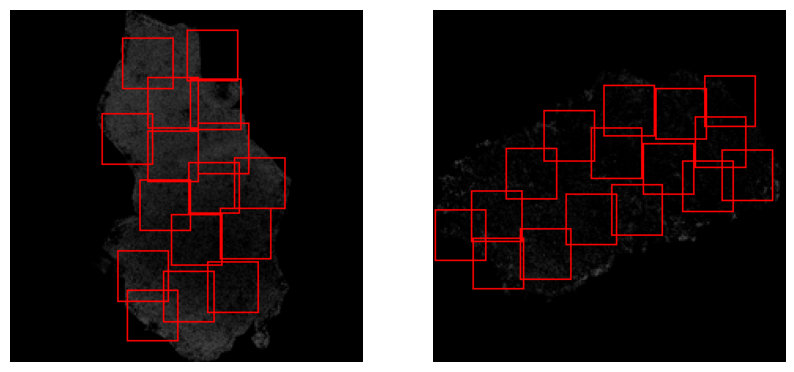

In [57]:
# Display some example images and their sampled coordinates
img1, label1, mask1 = dataset[15] # example 1
img2, label2, mask2 = dataset[49] # example 2
coords1 = sample_coordinates_from_roi(mask1, 16, 32, 0.2)
coords2 = sample_coordinates_from_roi(mask2, 16, 32, 0.2)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()
plot_sampled_patches(img1, coords1, 32, ax=axes[0])
plot_sampled_patches(img2, coords2, 32, ax=axes[1])

In [59]:
patches_by_label = create_patches_by_label(dataset, 16, 32, 0.2)

In [60]:
draw_size = 49 # there are 49 of 32x32 patches in a 224x224 picture
num_draws = 100  # draw pictures for example   

# randomly drawing 49 samples 100 times from the patches_by_label 
example_patches_0 = [random.sample(patches_by_label[0], draw_size) for _ in range (num_draws)]
example_patches_1 = [random.sample(patches_by_label[1], draw_size) for _ in range(num_draws)]

# shuffle the list of patches
random.shuffle(example_patches_0)
random.shuffle(example_patches_1)

In [61]:
positive_quilts = []
negative_quilts = []
# generate 50 quilted for 50 positive examples and 50 negative examples
for i in range(50):
    positive_quilted_np = np.array(quilting_image(random.choice(example_patches_0), random.choice(example_patches_0), 32, 0.5)).flatten()
    negative_quilted_np = np.array(quilting_image(random.choice(example_patches_0), random.choice(example_patches_1), 32, 0.5)).flatten()
    positive_quilts.append(positive_quilted_np)
    negative_quilts.append(negative_quilted_np)

/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP processing completed in 0.21 seconds
Processed 100 images with dimensionality 50176


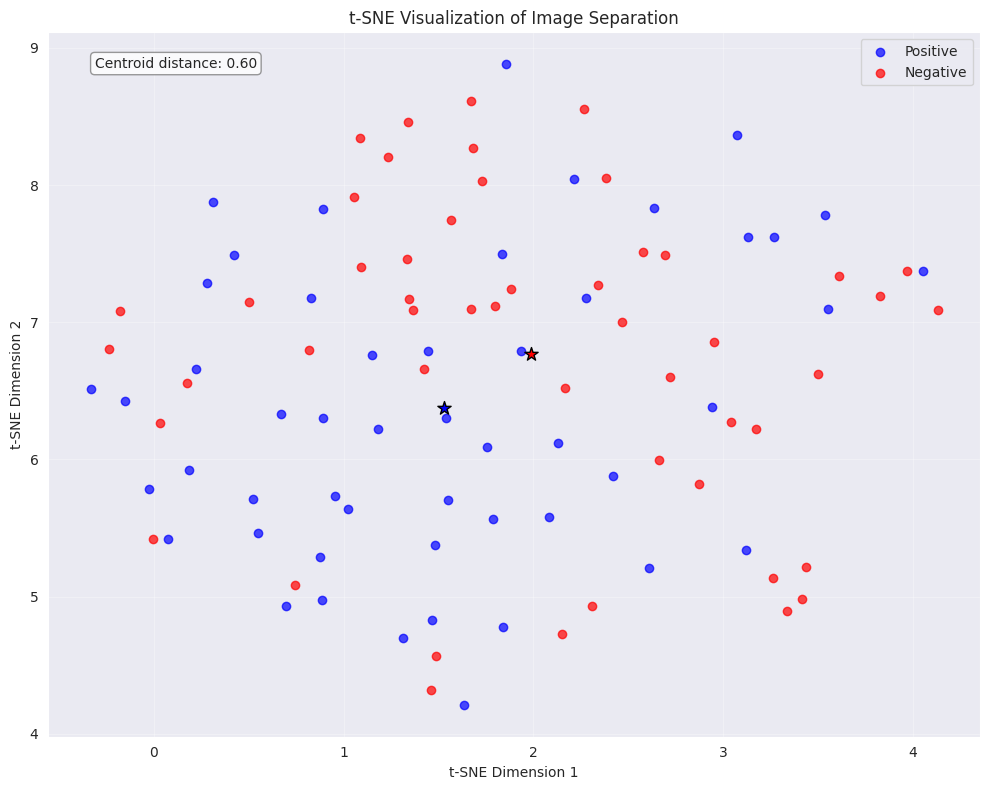

In [62]:
embeddings, labels = umap_reduce(negative_quilts, positive_quilts)
plot = plot_separation(embeddings, labels)
plot.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.004s...
[t-SNE] Computed neighbors for 100 samples in 0.299s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 86.779981
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.683414
[t-SNE] KL divergence after 1000 iterations: 0.689088
t-SNE processing completed in 1.02 seconds
Processed 100 images with dimensionality 50176


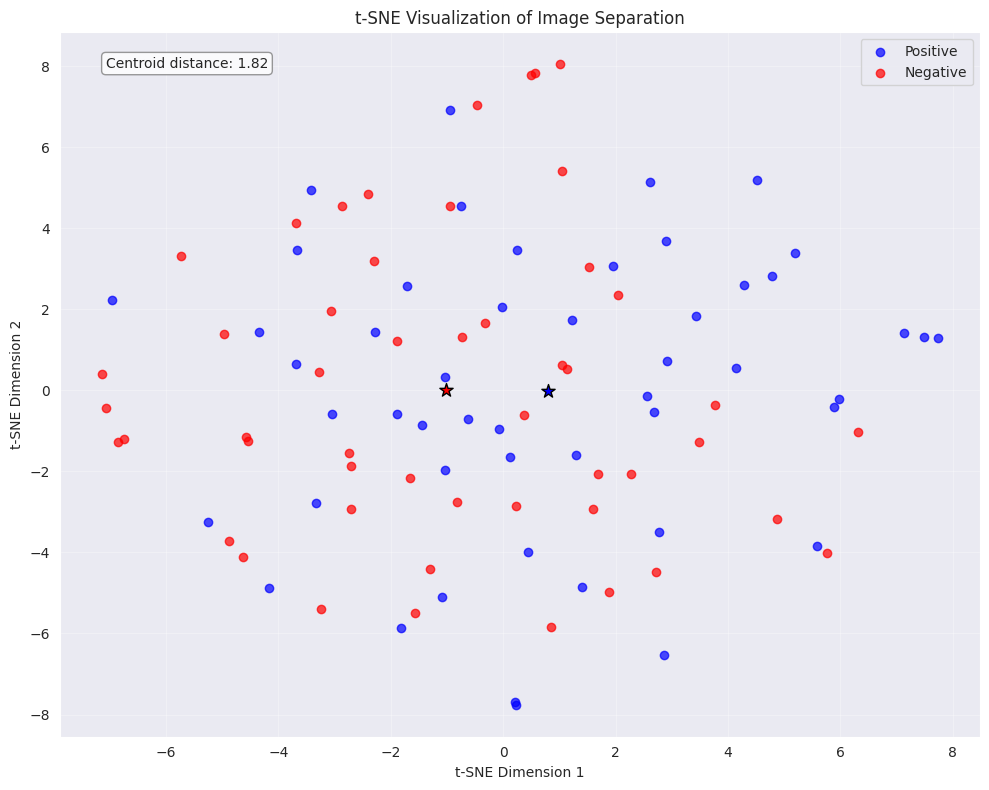

In [63]:
embeddings, labels = tsne_reduce(negative_quilts, positive_quilts)
plot = plot_separation(embeddings, labels)
plot.show()